In [33]:
# Import Libraries
# =========================================================

import numpy as np
import pandas as pd
from collections import Counter
from itertools import product
import warnings

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import plotly.offline as pyo

## GLOBAL SETTINGS
pd.options.mode.chained_assignment = None  # default='warn'
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('ggplot')
pd.set_option('display.max_rows', 500)
pd.options.display.float_format = '{:,.2f}'.format
plt.rcParams['savefig.bbox'] = "tight"

In [185]:
def missing_summary(df):
    has_non = 0
    for column in df.columns:
        total_values = len(df)
        missing_values = df[column].isnull().sum()
        percentage = ((missing_values/total_values)*100).round(2)
        if missing_values > 0:
            print('df["{}"] - Total values: {}, Missing values: {} ({}%)'.format(column, total_values, missing_values, percentage,))
        else:
            has_non += 1
    if has_non == len(df.columns):
        print("Provided dataframe does not have any missing values.")

# =========================================================
def categorical_counter(data):
    for column in data.select_dtypes(exclude = np.number).columns:
        cat_length = len(data[column].unique())
        print(f"df[\"{column}\"] contains {cat_length} unique values.")

# =========================================================
def numerical_distribution(df,feature, feature_2):
    
    print(f"{feature} Overview:")
    integers = range(len(df[feature]))
    fig = sns.scatterplot(data = df, 
        x = integers, 
        y = feature, 
        hue = feature_2, 
        style = feature_2)
 
    print(99*"#")
    quartile_1, quartile_3 = np.percentile(df[feature], [25, 75])
    IQR= quartile_3 - quartile_1
   
    median = np.median(df[feature])
    absolute_deviations = np.abs(df[feature] - median)
    median_absolute_deviation = np.median(absolute_deviations)
    mcv = median_absolute_deviation / median

    print(f"Summary statistics\n {df[[feature]].describe()}")
    print()
    print('Outliers analysis:\n')
    print(f'IQR: {IQR} || (median_abs_deviation): {median_absolute_deviation}|| The Median-based index: {mcv} ')

# =========================================================
def feature_vs_target_w_lengh(data, feature, TARGET):
    sleep_pivot = data.pivot_table(
        index = [feature], values = TARGET,
        aggfunc = [len, sum, np.mean]).sort_values(by = [("mean", TARGET)], ascending = False)

    fig, ax = plt.subplots()
    scatter = ax.scatter(
        sleep_pivot.index, sleep_pivot[("mean", TARGET)], c = sleep_pivot[("len", TARGET)], 
        cmap = "viridis", alpha = 0.5)
    ax.set_xlabel(feature)
    ax.set_ylabel(TARGET + " rate")
    ax.set_title(feature + " vs " + TARGET + " Rate")
    cbar = fig.colorbar(scatter)
    cbar.set_label("len")
    plt.show()

# =========================================================
def four_feature_scatterer(data, cat, x, y, size, title = "Title"):
    vis = data.groupby([cat])[x, y, size].median().sort_values(by = y, ascending = False)
    fig = px.scatter(vis, x = x, y = y, color = vis.index, size = size)
    fig.update_layout(
        barmode = "overlay",
        title = {
            "text": "<b>" + title + "</b>",
            "x": 0.5,
            "xanchor": "center"},      
        height = 600)
    fig.show()
    fig.show("png")

In [35]:
df = pd.read_csv("Bobs_df.csv")
df.drop("Unnamed: 0", axis = 1, inplace = True)

<h3>Feature Name and Description</h3>

**active_customer**: 
Client activity indicator in our application

**age**: 
Customer age

**country_id**: 
Country of residence of the client

**credit_card**: 
Credit cards

**debit_card**: 
Debit card

**deceased**: 
Deceased index. N/S

**em_account_p**: 
easyMoney+ account

**em_account_pp**: 
easyMoney++ acount

**em_acount**: 
easyMoney account

**emc_account**: 
easyMoney Crypto account

**entry_channel**: 
Customer acquisition channel

**entry_date**: 
Date on which first easyMoney contract was signed

**funds**: 
Investment funds

**gender**: 
Gender

**loans**: 
Loans

**long_term_deposit**: 
Long term deposits

**mortgage**: 
Mortgage

**payroll**: 
payroll

**payroll_account**: 
Account awarded with a bonus due to payroll

**pension_plan**: 
Pension plan

**pk_cid**: 
Customer identifier

**pk_partition**: 
Data ingestion date

**region_code**: 
Customer's province of residence (for ES)

**salary**: 
Household gross income

**securities**: 
Securities

**segment**: 
Customer business segment

**short_term_deposit**: 
Short-term deposits


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5962924 entries, 0 to 5962923
Data columns (total 27 columns):
 #   Column              Dtype  
---  ------              -----  
 0   pk_cid              int64  
 1   pk_partition        object 
 2   country_id          object 
 3   region_code         float64
 4   gender              object 
 5   age                 int64  
 6   deceased            object 
 7   salary              float64
 8   short_term_deposit  int64  
 9   loans               int64  
 10  mortgage            int64  
 11  funds               int64  
 12  securities          int64  
 13  long_term_deposit   int64  
 14  em_account_pp       int64  
 15  credit_card         int64  
 16  payroll             float64
 17  pension_plan        float64
 18  payroll_account     int64  
 19  emc_account         int64  
 20  debit_card          int64  
 21  em_account_p        int64  
 22  em_acount           int64  
 23  entry_date          object 
 24  entry_channel       obje

In [37]:
df.describe(include = ["object"]).T

,count,unique,top,freq
pk_partition,5962924,17,2019-05-28,442995
country_id,5962924,41,ES,5960672
gender,5962899,2,H,3087502
deceased,5962924,2,N,5961849
entry_date,5962924,1499,2017-07-28,57389
entry_channel,5829891,68,KHE,3113947
segment,5828980,3,03 - UNIVERSITARIO,3900166


In [38]:
df.describe(include = np.number).T

,count,mean,std,min,25%,50%,75%,max
pk_cid,"5,962,924.00","1,234,929.80","162,302.04","15,891.00","1,112,532.00","1,231,097.00","1,352,339.00","1,553,689.00"
region_code,"5,960,660.00",25.81,13.60,1.00,13.00,28.00,36.00,52.00
age,"5,962,924.00",29.76,11.98,2.00,22.00,25.00,34.00,105.00
salary,"4,450,821.00","115,816.72","199,551.89","1,202.73","61,500.63","88,654.65","131,669.91","28,894,395.51"
short_term_deposit,"5,962,924.00",0.00,0.05,0.00,0.00,0.00,0.00,1.00
loans,"5,962,924.00",0.00,0.01,0.00,0.00,0.00,0.00,1.00
mortgage,"5,962,924.00",0.00,0.01,0.00,0.00,0.00,0.00,1.00
funds,"5,962,924.00",0.00,0.06,0.00,0.00,0.00,0.00,1.00
securities,"5,962,924.00",0.00,0.06,0.00,0.00,0.00,0.00,1.00
long_term_deposit,"5,962,924.00",0.02,0.13,0.00,0.00,0.00,0.00,1.00


In [39]:
missing_summary(df)

df["region_code"] - Total values: 5962924, Missing values: 2264 (0.04%)
df["gender"] - Total values: 5962924, Missing values: 25 (0.0%)
df["salary"] - Total values: 5962924, Missing values: 1512103 (25.36%)
df["payroll"] - Total values: 5962924, Missing values: 61 (0.0%)
df["pension_plan"] - Total values: 5962924, Missing values: 61 (0.0%)
df["entry_channel"] - Total values: 5962924, Missing values: 133033 (2.23%)
df["segment"] - Total values: 5962924, Missing values: 133944 (2.25%)


In [40]:
categorical_counter(df)

df["pk_partition"] contains 17 unique values.
df["country_id"] contains 41 unique values.
df["gender"] contains 3 unique values.
df["deceased"] contains 2 unique values.
df["entry_date"] contains 1499 unique values.
df["entry_channel"] contains 69 unique values.
df["segment"] contains 4 unique values.


In [ ]:
df["segment"] = df["segment"].str.replace("03 - UNIVERSITARIO", "student")
df["segment"] = df["segment"].str.replace("02 - PARTICULARES", "regular")
df["segment"] = df["segment"].str.replace("01 - TOP", "top")

In [41]:
## we have 25 cases without gender. we'll just make them female for now
df = df.rename(columns = { "gender": "Male" })
df["Male"] = df["Male"].map(lambda x: 1 if x == "H" else 0)

df["Male"].value_counts()

1    3087502
0    2875422
Name: Male, dtype: int64

In [204]:
df["salary_LN"] = df["salary"].apply(lambda x: np.log1p(x))

In [42]:
df["deceased"] = df["deceased"].map(lambda x: 1 if x == "S" else 0)
df["deceased"].value_counts()

0    5961849
1       1075
Name: deceased, dtype: int64

In [43]:
df["pk_partition"] = pd.to_datetime(df["pk_partition"])
df["entry_date"] = pd.to_datetime(df["entry_date"], errors='coerce')
df["entry_date"] = df["entry_date"].where(df["entry_date"].notna(), df["entry_date"].dt.floor("d") - pd.DateOffset(days = 1))

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5962924 entries, 0 to 5962923
Data columns (total 27 columns):
 #   Column              Dtype         
---  ------              -----         
 0   pk_cid              int64         
 1   pk_partition        datetime64[ns]
 2   country_id          object        
 3   region_code         float64       
 4   Male                int64         
 5   age                 int64         
 6   deceased            int64         
 7   salary              float64       
 8   short_term_deposit  int64         
 9   loans               int64         
 10  mortgage            int64         
 11  funds               int64         
 12  securities          int64         
 13  long_term_deposit   int64         
 14  em_account_pp       int64         
 15  credit_card         int64         
 16  payroll             float64       
 17  pension_plan        float64       
 18  payroll_account     int64         
 19  emc_account         int64         
 20  de

In [45]:
df["pk_cid"] = df["pk_cid"].astype(str)
df["region_code"] = df["region_code"].astype(str)

<AxesSubplot:title={'center':'Number of new registrations over time'}, xlabel='entry_date'>

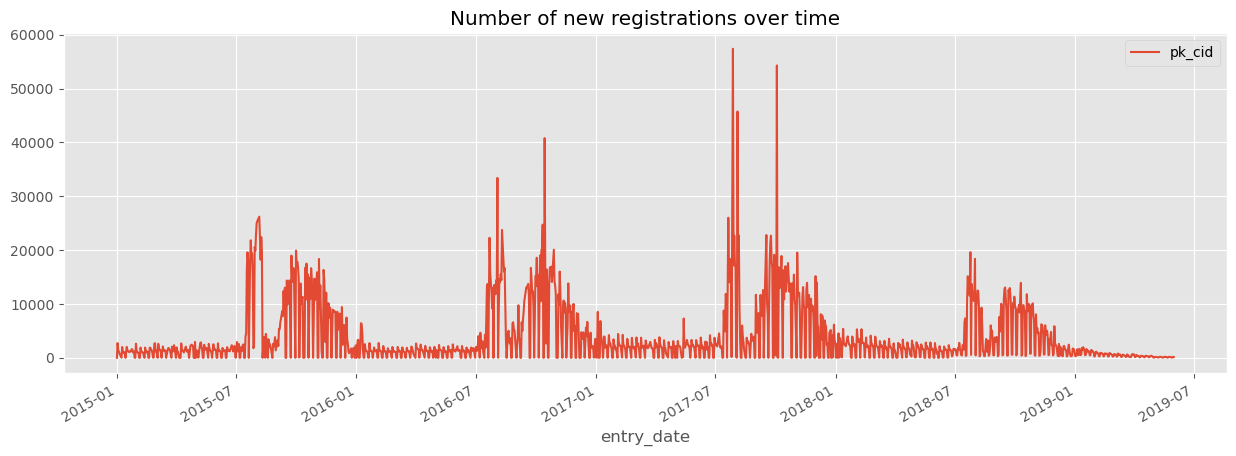

In [46]:
df.groupby("entry_date").agg({"pk_cid": "count"}).plot(figsize = (15, 5), title = "Number of new registrations over time")

<AxesSubplot:title={'center':'Customer growth over time'}, xlabel='pk_partition'>

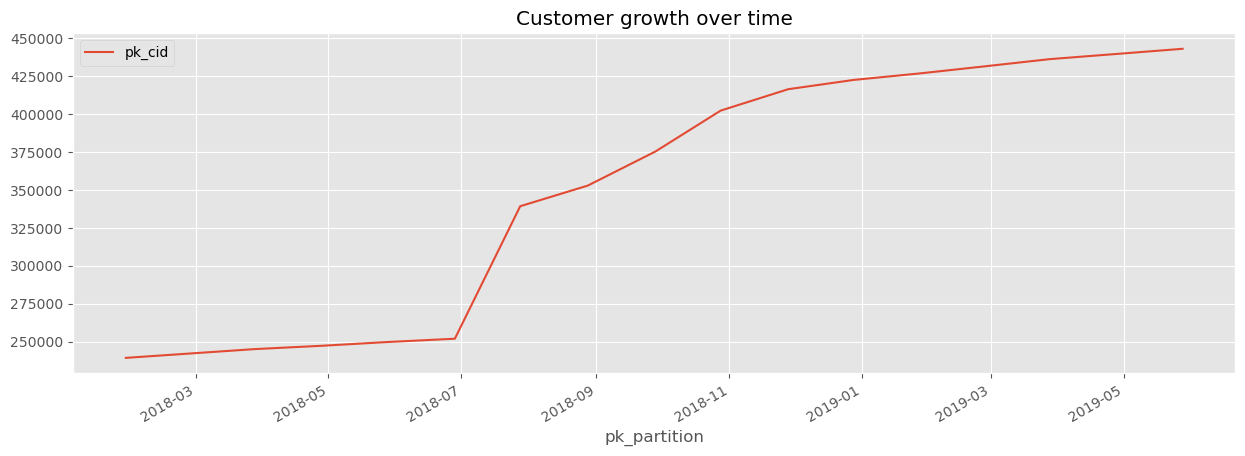

In [47]:
df.groupby("pk_partition").agg({"pk_cid": "count"}).plot(figsize = (15, 5), title = "Userbase growth over time")

<AxesSubplot:title={'center':'Distribution of age'}, ylabel='Frequency'>

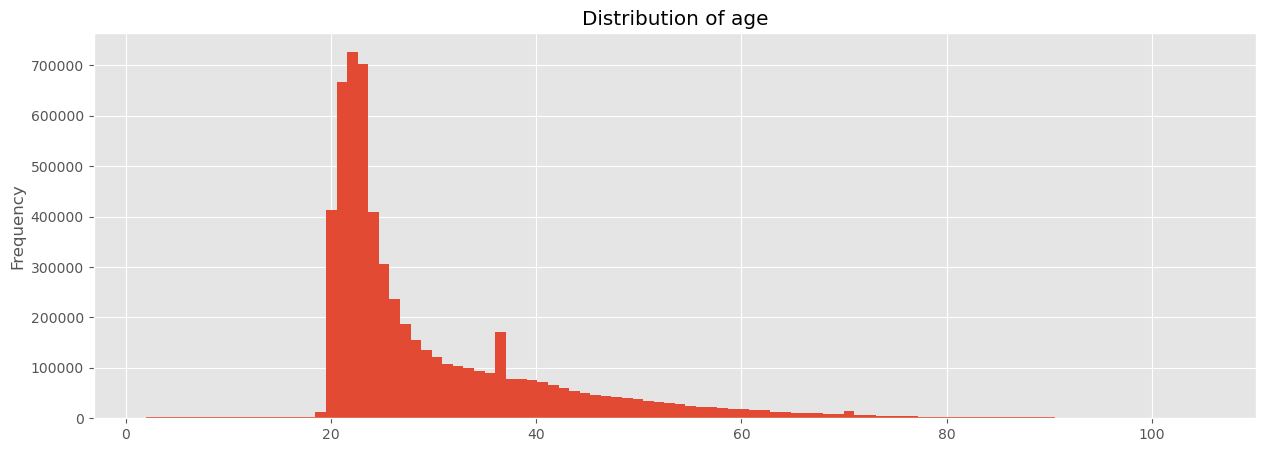

In [48]:
df["age"].plot(kind = "hist", bins = 100, figsize = (15, 5), title = "Distribution of age")

<AxesSubplot:title={'center':'Distribution of salaries'}, ylabel='Frequency'>

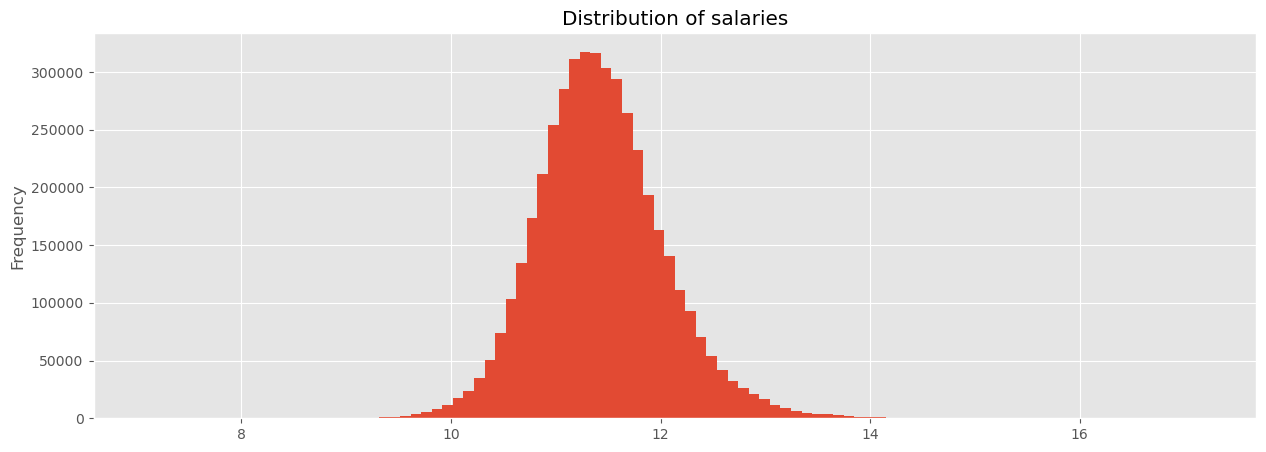

In [206]:
df["salary_LN"].plot(kind = "hist", bins = 100, figsize = (15, 5), title = "Distribution of salaries")

In [49]:
unique_values = df.nunique()
binary_features = unique_values[unique_values < 4].index.tolist()

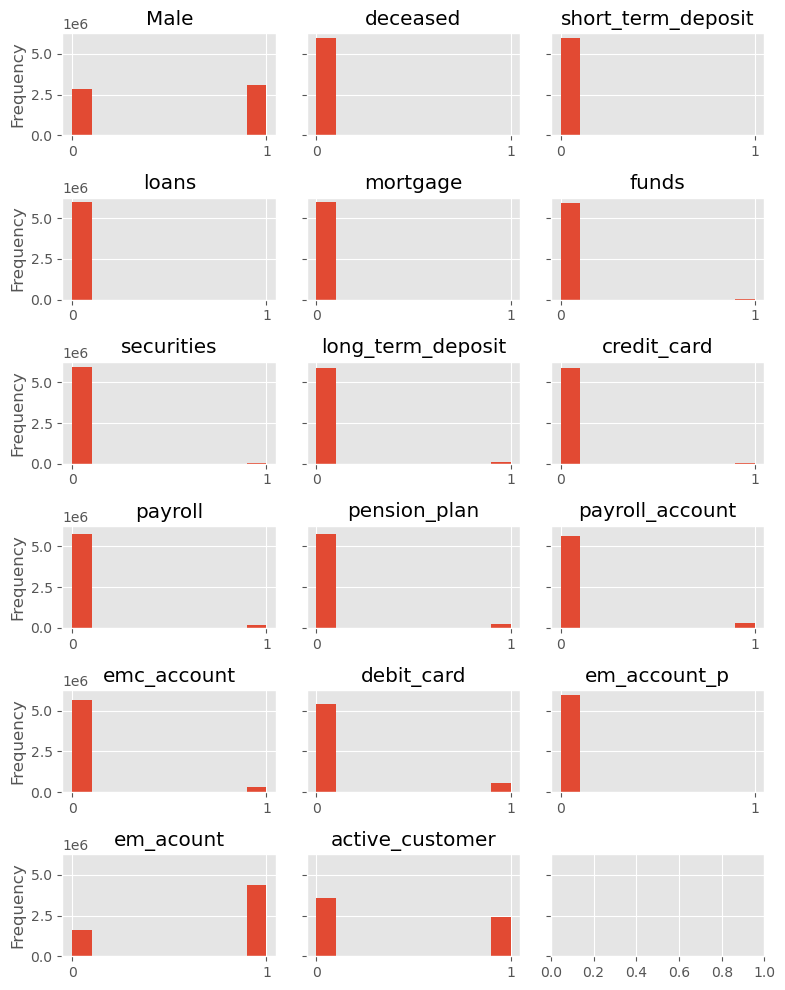

In [50]:
unique_values = df.nunique()
binary_features = unique_values[unique_values == 2].index.tolist()
n_features = len(binary_features)
rows = (n_features // 3) + (n_features % 3 != 0)
cols = 3
fig, ax = plt.subplots(rows, cols, figsize = (8, 10), sharey=True)

if rows > 1:
    ax = ax.flatten()
for i, column in enumerate(binary_features):
    df[column].plot(kind = "hist", ax=ax[i], title = column)
    ax[i].set_xticks([0, 1])

plt.tight_layout()
plt.show()

In [51]:
categorical_counter(df)

df["pk_cid"] contains 456373 unique values.
df["pk_partition"] contains 17 unique values.
df["country_id"] contains 41 unique values.
df["region_code"] contains 53 unique values.
df["entry_date"] contains 1498 unique values.
df["entry_channel"] contains 69 unique values.
df["segment"] contains 4 unique values.


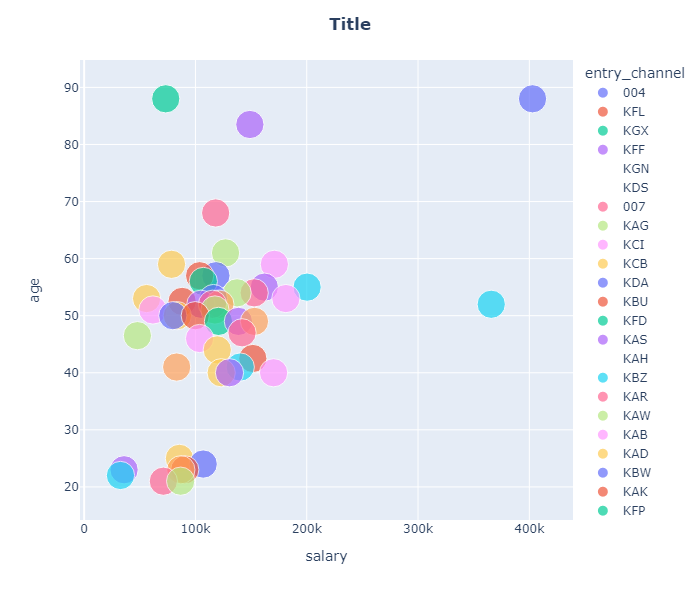

In [211]:
# 80-180k + 40-60 years "cluster"
# around 80k + 20-25 years "cluster"

four_feature_scatterer(df, "entry_channel", "salary", "age", "Male", title = "Title")

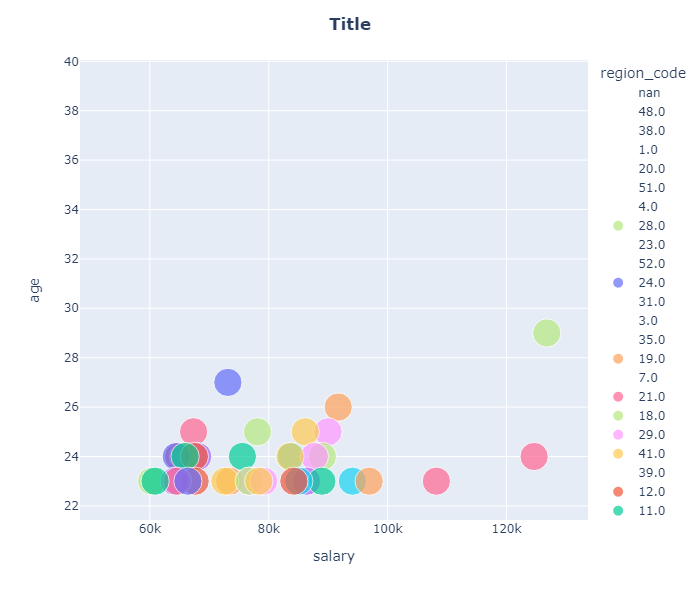

In [214]:
# 1. Provided salary only for age range 22-40
# 2. Majority of the customers below 26 years old
# 3. Majority of the customers between 60 and 90k salary

four_feature_scatterer(df, "region_code", "salary", "age", "Male", title = "Title")

In [178]:
#top 20 value counts

features = ["age", "entry_channel", "country_id", "region_code", "segment"]
sorted_counts = pd.DataFrame()

for feature in features:
    temp = pd.DataFrame(df[feature].value_counts()).reset_index()
    temp = temp.sort_values(by = feature, ascending = False)
    sorted_counts = pd.concat([sorted_counts, temp], axis = 1, ignore_index = True)

sorted_counts.columns = ["age", "#", "entry", "#", "country", "#", "region", "#", "seg", "#"]
sorted_counts[:20]

,age,#,entry,#,country,#,region,#,seg,#
0,22,727134,KHE,"3,113,947.00",ES,"5,960,672.00",28.0,"1,185,757.00",student,"3,900,166.00"
1,23,702127,KFC,"890,620.00",GB,441.00,8.0,"600,362.00",regular,"1,830,875.00"
2,21,667762,KHQ,"590,280.00",FR,225.00,46.0,"358,142.00",top,"97,939.00"
3,20,413568,KAT,"416,084.00",DE,199.00,30.0,"296,856.00",NaN,NaN
4,24,408569,KHK,"230,197.00",US,195.00,41.0,"290,447.00",NaN,NaN
5,25,305028,KHM,"176,591.00",CH,194.00,15.0,"254,891.00",NaN,NaN
6,26,237454,KHN,"108,434.00",BR,87.00,29.0,"187,911.00",NaN,NaN
7,27,186277,KFA,"79,020.00",BE,81.00,36.0,"175,850.00",NaN,NaN
8,28,156142,KHD,"75,899.00",VE,79.00,3.0,"171,358.00",NaN,NaN
9,29,134814,RED,"60,601.00",IE,68.00,11.0,"160,894.00",NaN,NaN


# AGE vs binaries

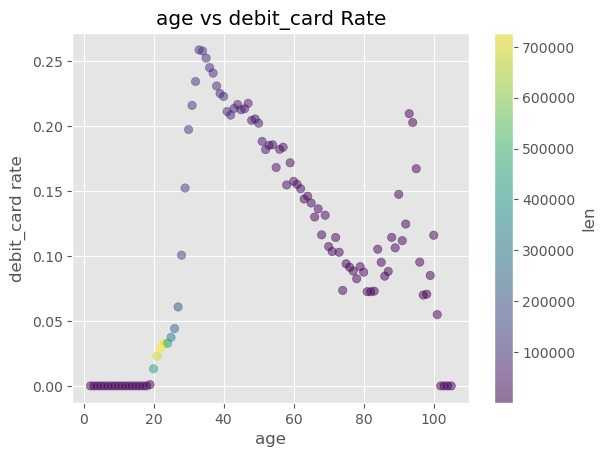

In [199]:
feature_vs_target_w_lengh(df, "age", "debit_card")

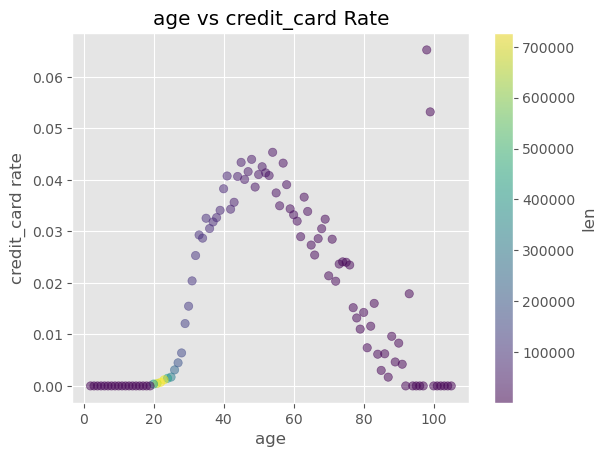

In [198]:
feature_vs_target_w_lengh(df, "age", "credit_card")

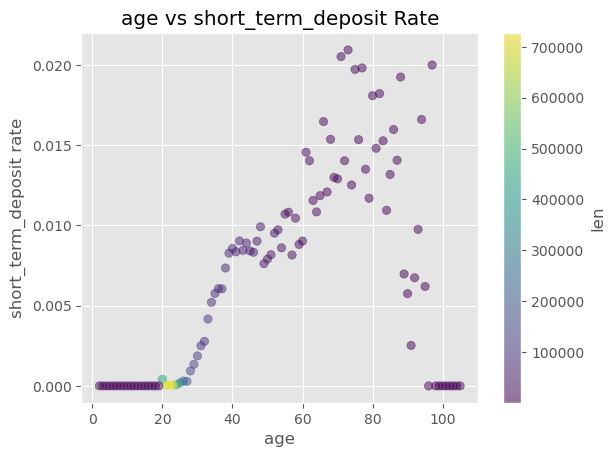

In [197]:
feature_vs_target_w_lengh(df, "age", "short_term_deposit")

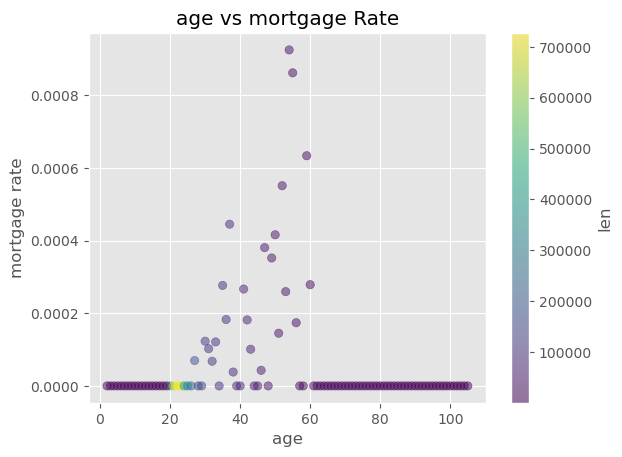

In [196]:
feature_vs_target_w_lengh(df, "age", "mortgage")

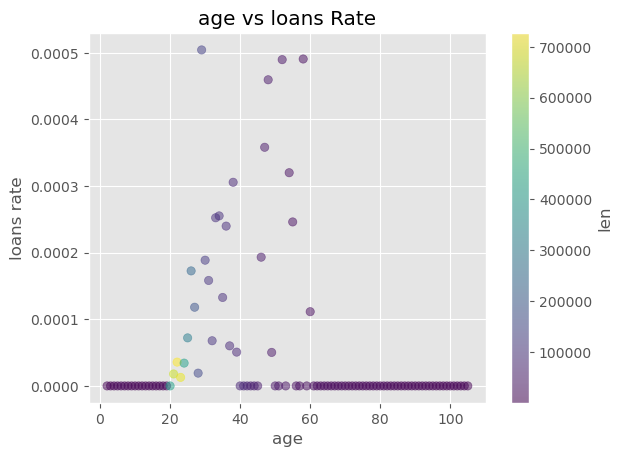

In [195]:
feature_vs_target_w_lengh(df, "age", "loans")

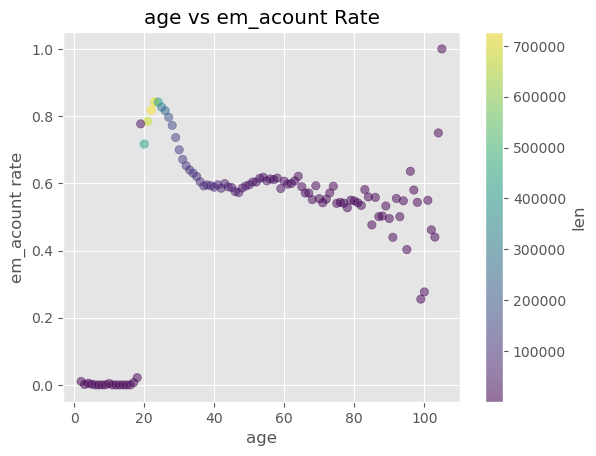

In [193]:
feature_vs_target_w_lengh(df, "age", "em_acount")

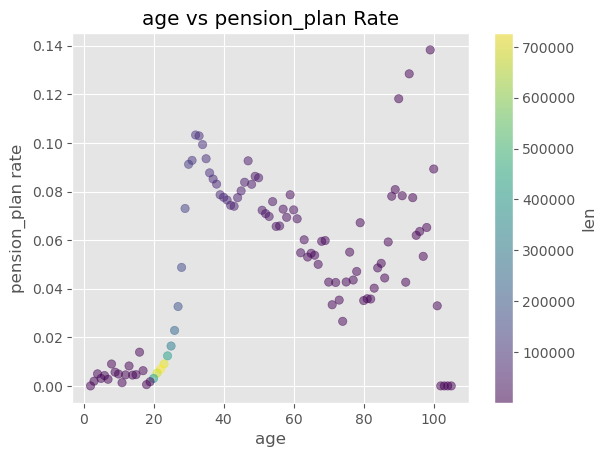

In [194]:
feature_vs_target_w_lengh(df, "age", "pension_plan")

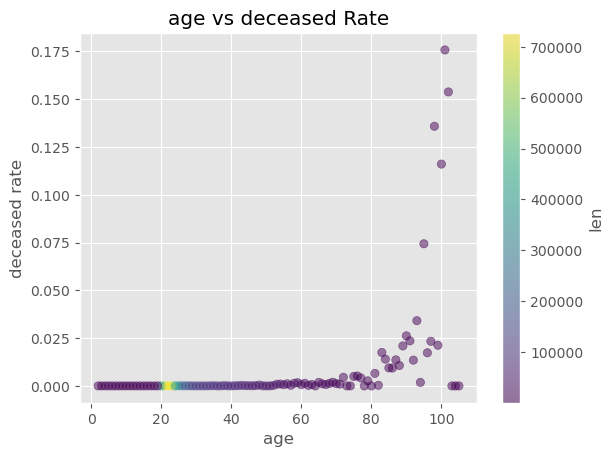

In [187]:
feature_vs_target_w_lengh(df, "age", "deceased")

# Salary (log) vs binaries

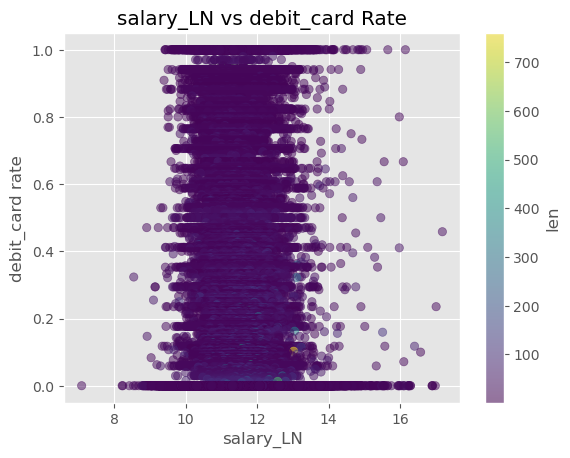

In [224]:

feature_vs_target_w_lengh(df, "salary_LN", "debit_card")

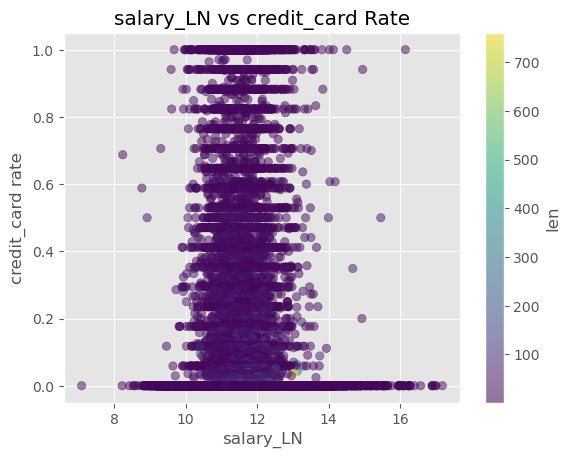

In [223]:
feature_vs_target_w_lengh(df, "salary_LN", "credit_card")

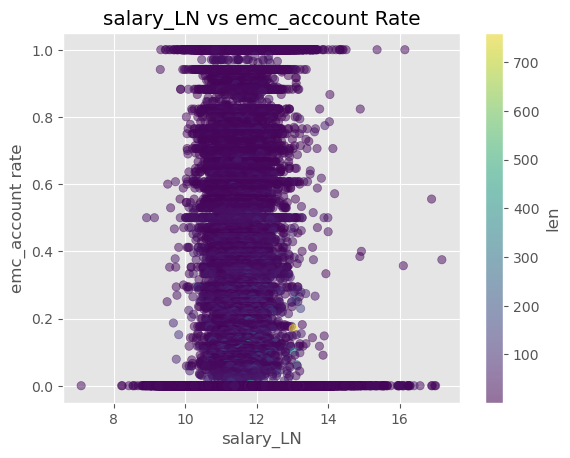

In [222]:
feature_vs_target_w_lengh(df, "salary_LN", "emc_account")

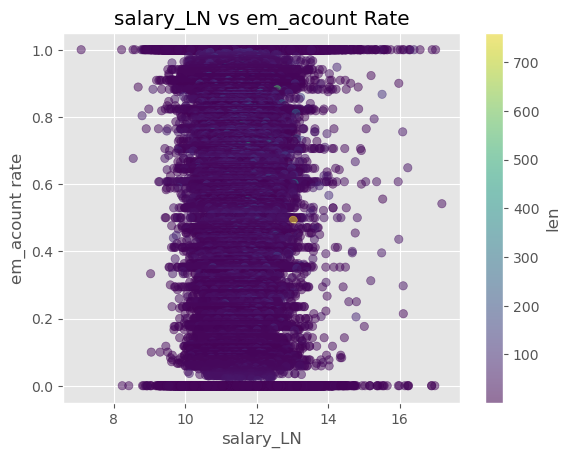

In [225]:
feature_vs_target_w_lengh(df, "salary_LN", "em_acount")

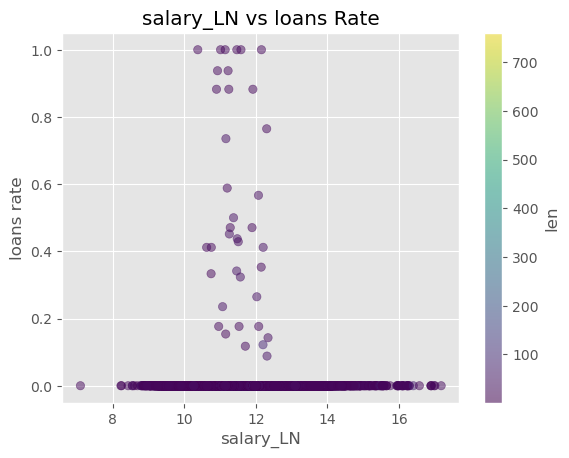

In [227]:
feature_vs_target_w_lengh(df, "salary_LN", "loans")

# entry date vs binaries

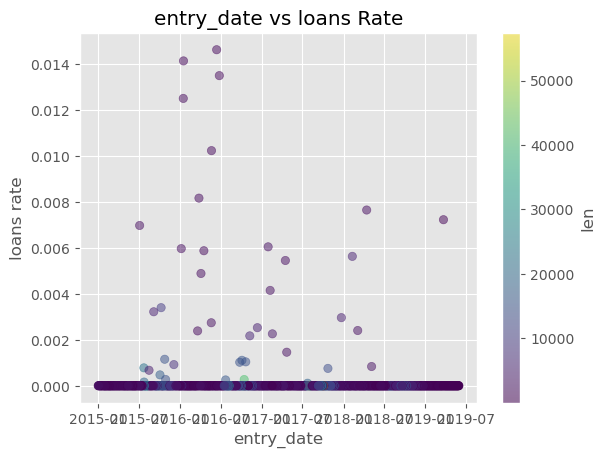

In [228]:
feature_vs_target_w_lengh(df, "entry_date", "loans")

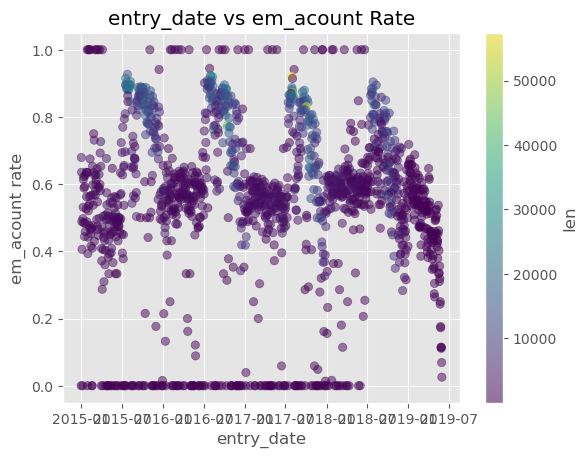

In [230]:
feature_vs_target_w_lengh(df, "entry_date", "em_acount")

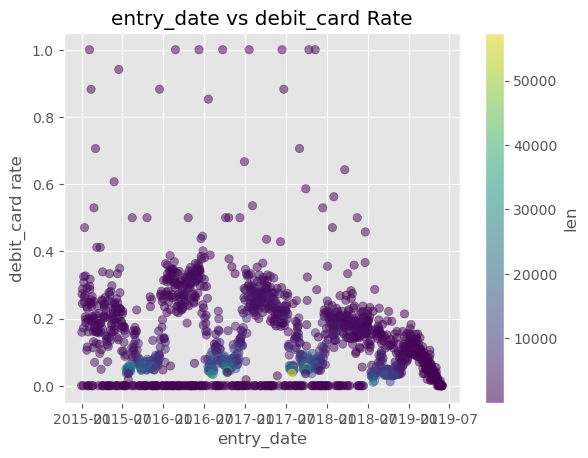

In [231]:
feature_vs_target_w_lengh(df, "entry_date", "debit_card")

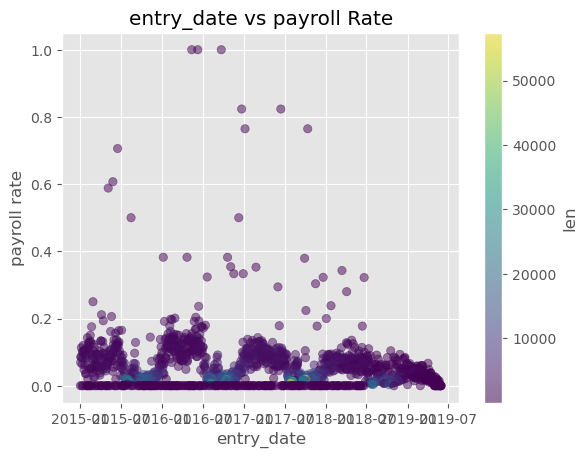

In [232]:
feature_vs_target_w_lengh(df, "entry_date", "payroll")

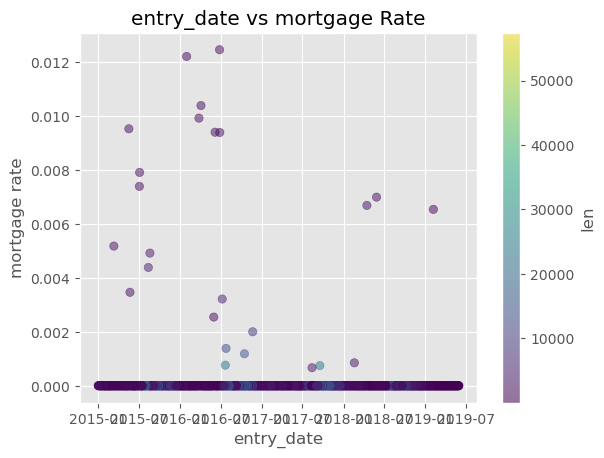

In [233]:
feature_vs_target_w_lengh(df, "entry_date", "mortgage")

In [63]:
df["em_acount"].value_counts()

1    4381602
0    1581322
Name: em_acount, dtype: int64

In [87]:
df[df["em_acount"] == 0]["pk_cid"].unique()[:30]

array(['1050613', '1050680', '1050693', '1050660', '1050642', '1050651',
       '1050652', '1050658', '1050659', '1050553', '1050565', '1050537',
       '1050857', '1050869', '1050911', '1050914', '1050920', '1050141',
       '1050091', '1050155', '1050389', '1050337', '1050360', '1050358',
       '1051851', '1051852', '1051853', '1051854', '1051920', '1051968'],
      dtype=object)

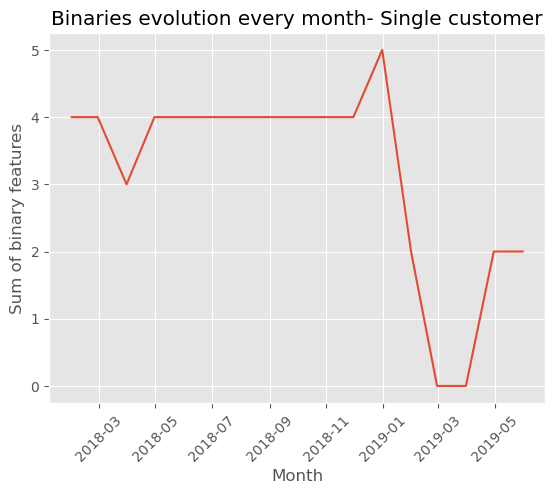

In [108]:
## this way we can see if and when something changed in a customer's account


df_monthly = df[df["pk_cid"] == "1050358"].resample("M", on = "pk_partition").sum()
plt.plot(df_monthly.index, df_monthly[["deceased", "short_term_deposit", "loans", "mortgage", "funds","securities", "long_term_deposit", "credit_card", "payroll","pension_plan", "payroll_account", "emc_account", "debit_card", "em_account_p", "em_acount", "active_customer"]].sum(axis = 1))

plt.xlabel("Month")
plt.ylabel("Sum of binary features")
plt.title("Binaries evolution every month- Single customer")
plt.xticks(rotation=45)
plt.show()

In [95]:
df[df["pk_cid"] == "1050358"].T

,606,473364,693955,969315,1007575,1258629,1583493,2050193,2330537,2673371,3335322,3416664,4163025,4547377,5074378,5270466,5775321
pk_cid,1050358,1050358,1050358,1050358,1050358,1050358,1050358,1050358,1050358,1050358,1050358,1050358,1050358,1050358,1050358,1050358,1050358
pk_partition,2018-01-28 00:00:00,2018-02-28 00:00:00,2018-03-28 00:00:00,2018-04-28 00:00:00,2018-05-28 00:00:00,2018-06-28 00:00:00,2018-07-28 00:00:00,2018-08-28 00:00:00,2018-09-28 00:00:00,2018-10-28 00:00:00,2018-11-28 00:00:00,2018-12-28 00:00:00,2019-01-28 00:00:00,2019-02-28 00:00:00,2019-03-28 00:00:00,2019-04-28 00:00:00,2019-05-28 00:00:00
country_id,ES,ES,ES,ES,ES,ES,ES,ES,ES,ES,ES,ES,ES,ES,ES,ES,ES
region_code,28.0,28.0,28.0,28.0,28.0,28.0,28.0,28.0,28.0,28.0,28.0,28.0,28.0,28.0,28.0,28.0,28.0
Male,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
age,31,31,31,31,31,31,31,31,31,32,32,32,32,32,32,32,32
deceased,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
salary,"70,641.48","70,641.48","70,641.48","70,641.48","70,641.48","70,641.48","70,641.48","70,641.48","70,641.48","70,641.48","70,641.48","70,641.48","70,641.48","70,641.48","70,641.48","70,641.48","70,641.48"
short_term_deposit,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
loans,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


<br>

# What happened on August/2018? Why the drop?

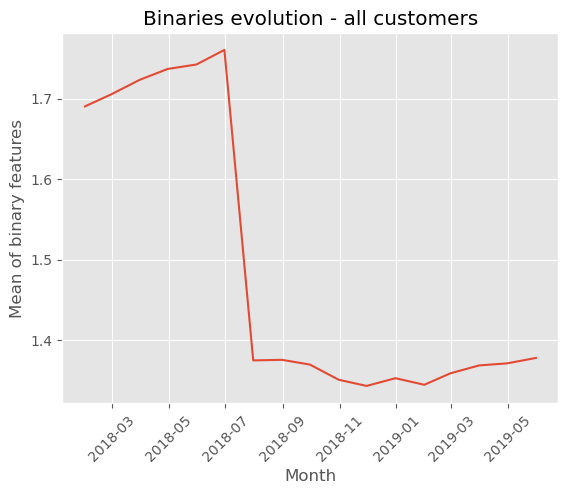

In [109]:
## in june 2018 something happened: the average sum of binary features dropped significantly

df_monthly = df.resample("M", on = "pk_partition").mean()
plt.plot(df_monthly.index, df_monthly[["deceased", "short_term_deposit", "loans", "mortgage", "funds","securities", "long_term_deposit", "credit_card", "payroll","pension_plan", "payroll_account", "emc_account", "debit_card", "em_account_p", "em_acount", "active_customer"]].sum(axis = 1))

plt.xlabel("Month")
plt.ylabel("Mean of binary features")
plt.title("Binaries evolution - all customers")
plt.xticks(rotation=45)
plt.show()

<br><br><br><br><br>
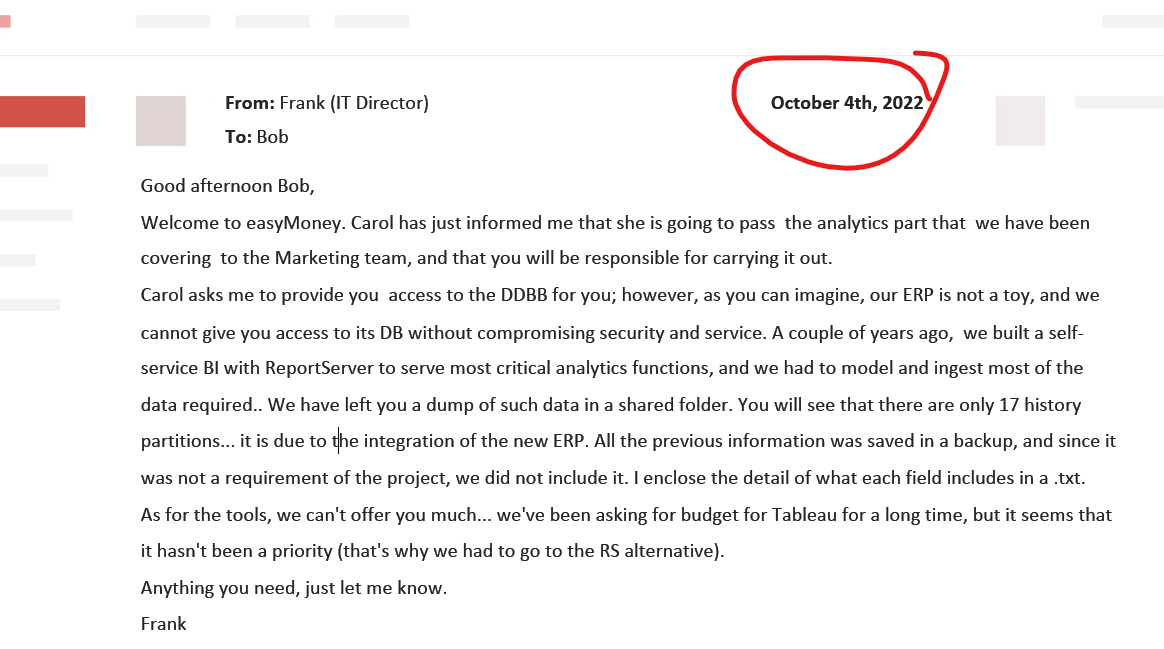

Considering that the last data entry we have is from mid 2019, this basically means we do not have any operational data from the last 2.5 years. We will be doing our entire analysis and any prediction/recommendation based on <u><b>2.5 year old</u></b> data.